# Import library

In [1]:
import os
import numpy as np
import glob
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Define dataset

In [5]:
def GetFileName(root,root_len):
    filenames = glob.glob(os.path.join(root, '*_image1.png'))
    #check if is nan
    label = pd.read_csv(root+ "/train.csv")
    label = label.dropna()
    label = label['id']
    label = label.array
    #delete nan hand
    count = len(filenames) - 1
    while (count >= 0):
        if (filenames[count][-(len(filenames[count]))+root_len+1:-11] not in label):
            filenames.remove(filenames[count])
        count = count - 1
    return filenames

def replication (paths,root_len):
    label = pd.read_csv('data_path/train.csv',index_col='id')
    orilen = len(paths)
    for i in range(orilen):
        if label.loc[paths[i][-(len(paths[i]))+root_len+1:-11]][0] == 1:
            paths.append(paths[i])
            #paths.append(paths[i])
            #paths.append(paths[i])
    return paths

class GetDataSet(Dataset):
    def __init__(self,file,file_paths,train=True):
        self.file_paths = file_paths #file names of images
        self.train = train
        self.resize = transforms.Resize((512,512))
        if (self.train):
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(180, expand=True),
                transforms.Resize((512,512)),
                transforms.RandomEqualize(1),
                transforms.ToTensor()
                ])
        else:
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomEqualize(1),
                transforms.ToTensor()
                ])
        self.num_samples = len(self.file_paths)
        self.filenames = glob.glob(os.path.join(os.path.join('data_path/',file), "*.png"))
        self.label = pd.read_csv('data_path/train.csv',index_col='id')
        self.train_folder = 'data_path/train'

    def __getitem__(self,idx):
        file_path = self.file_paths[idx]
        img1 = torchvision.io.read_image(file_path,torchvision.io.ImageReadMode(1))
        img1 = self.transforms(img1)
        img1 = self.padding(img1)
        check = 0
        if(file_path[-len(file_path):-5]+'2.png' in self.filenames):
            img2 = torchvision.io.read_image(file_path[-len(file_path):-5]+'2.png',torchvision.io.ImageReadMode(1))
            img2 = self.transforms(img2)
            img2 = self.padding(img2)
            check = check + 1
        if(file_path[-len(file_path):-5]+'3.png' in self.filenames):
            img3 = torchvision.io.read_image(file_path[-len(file_path):-5]+'3.png',torchvision.io.ImageReadMode(1))
            img3 = self.transforms(img3)
            img3 = self.padding(img3)
            check = check + 1
        if(file_path[-len(file_path):-5]+'4.png' in self.filenames):
            img4 = torchvision.io.read_image(file_path[-len(file_path):-5]+'4.png',torchvision.io.ImageReadMode(1))
            img4 = self.transforms(img4)
            img4 = self.padding(img4)
            check = check + 1
        if (check == 3):img = torch.cat((img1,img2,img3,img4))
        elif (check == 2):img = torch.cat((img1,img2,img3,img1))
        elif (check == 1):img = torch.cat((img1,img2,img1,img1))
        else:img = torch.cat((img1,img1,img1,img1))
        
        if (self.train):
            return img,self.label.loc[file_path[-len(file_path)+len(self.train_folder)+1:-11]][0]
        else:
            return img
        
    def __len__(self):
        return self.num_samples

    def padding(self,img):
        h = img.size()[0]
        w = img.size()[1]
        if w != 512 or h != 512:
            if h > w:
                img = F.pad(img,((h-w)/2),((h-w)/2),0,0)
            elif w < h:
                img = F.pad(img,(0,0,(w-h)/2),((w-h)/2),0,0)
            img = self.resize(img)
        return img



In [6]:
train_folder = 'data_path/train'
train_paths = GetFileName('data_path/train',len(train_folder))
train_paths = replication(train_paths,len(train_folder))
test_paths = glob.glob(os.path.join('data_path/test', '*_image1.png'))
train_dataset = GetDataSet('train',train_paths,train = True)
test_dataset = GetDataSet('test',test_paths,train = False)

In [7]:
print(len(train_dataset))
print(len(test_dataset))

3525
500


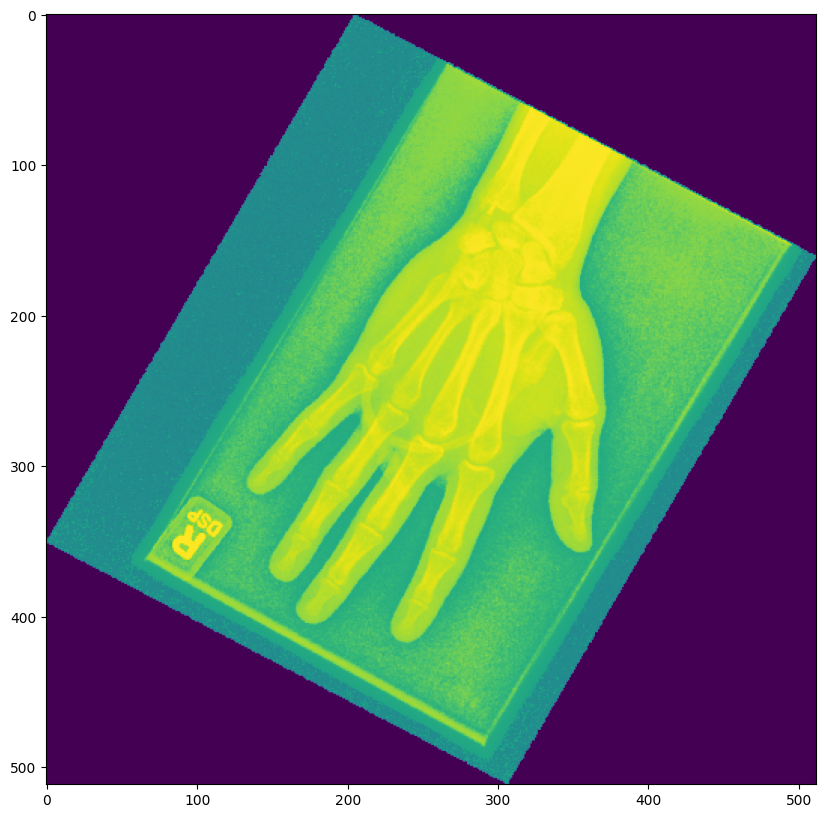

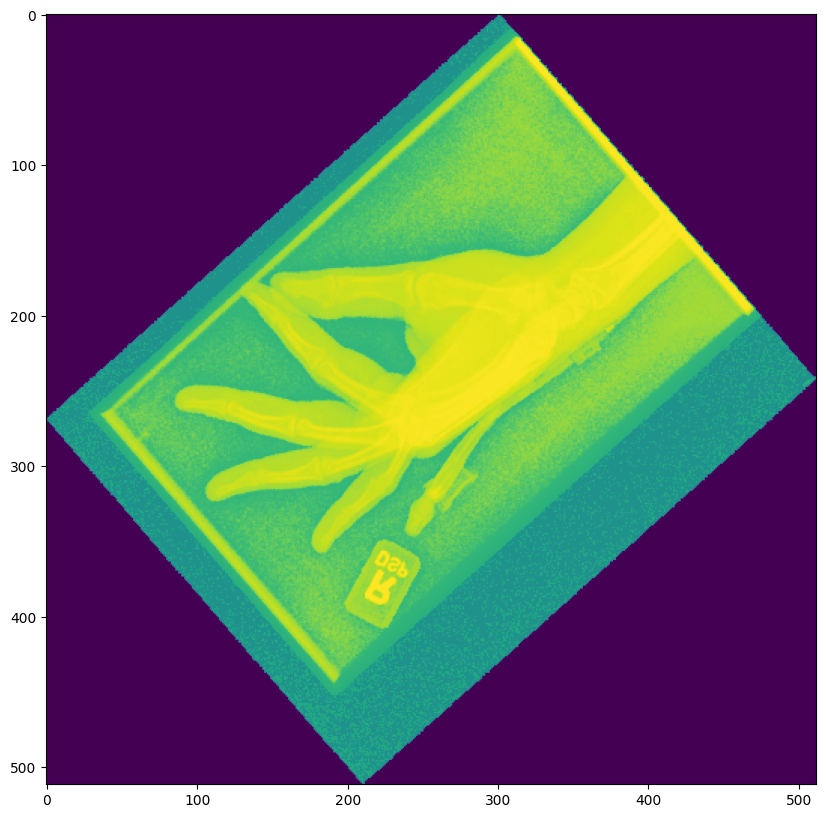

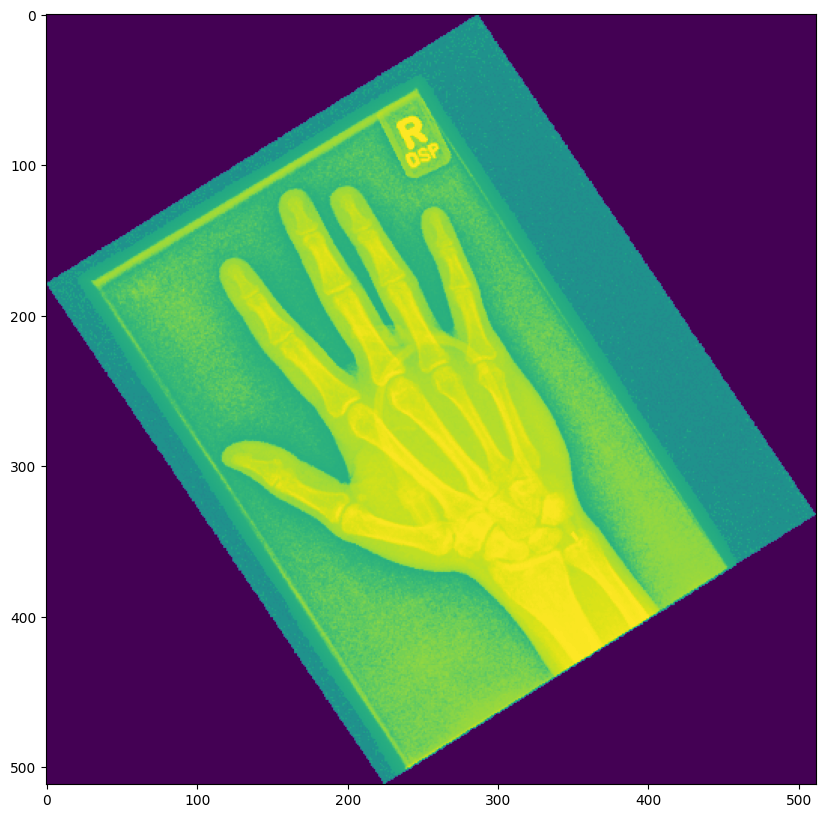

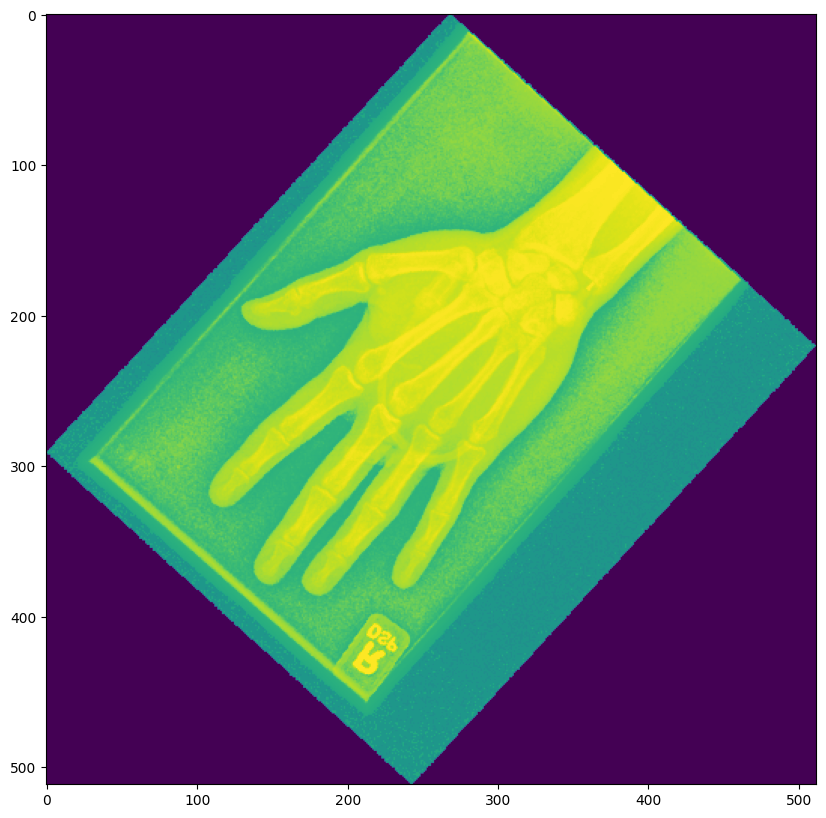

In [8]:
#check dataset
#the first index stands for the index of the images
#the second index implies it is the image not the label
#the third is the index of the channel
img = train_dataset[1][0][0] 
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = train_dataset[1][0][1]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = train_dataset[1][0][2]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = train_dataset[1][0][3]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [9]:
#construct data loader
import torch.utils.data as data
batch_size = 8
VAL_RATIO = 0.2
percent = int(len(train_dataset) * (1 - VAL_RATIO))
train_set, valid_set = data.random_split(train_dataset, [percent, len(train_dataset)-percent])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# Define model

In [10]:
#!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [11]:
#get pretrained model using torchvision.models as models library
from torch.autograd import Variable
import segmentation_models_pytorch as smp

model = smp.Unet('resnet50', encoder_weights='imagenet')
#turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

#change the number of input channels to 4 
weight1 = model.encoder.conv1.weight.clone()
new_first_layer  = nn.Conv2d(4, model.encoder.conv1.out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).requires_grad_()
new_first_layer.weight[:,:3,:,:].data[...] =  Variable(weight1, requires_grad=True)
model.encoder.conv1 = new_first_layer

#check model weight
print(model.encoder.conv1.weight.size())

torch.Size([64, 4, 7, 7])


In [12]:
model.segmentation_head = nn.Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [13]:
# Find the device available to use using torch library
device = torch.device("cuda")
#device = "cpu"
# Move model to the device specified above
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [14]:

#create new classifier for model using torch.nn as nn library
classifier_input = resnet.fc.in_features
num_labels = 2 #PUT IN THE NUMBER OF LABELS IN YOUR DATA
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))
#replace default classifier with new classifier
resnet.fc = classifier

Using cache found in /home/u3675487/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
#get pretrained model using torchvision.models as models library
from torch.autograd import Variable
#resnet = torch.hub.load('pytorch/vision:v0.14.0', 'resnet50', pretrained=True)
resnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
#turn off training for their parameters
for param in resnet.parameters():
    param.requires_grad = False


In [15]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [16]:
device

device(type='cuda')

In [17]:
#set the error function using torch.nn as nn library
criterion = nn.NLLLoss()
#set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.parameters(),lr = 0.0005)

In [18]:
from tqdm import tqdm

Training...: 100%|██████████| 353/353 [02:13<00:00,  2.63it/s, Batch average loss=0.6883]


The saved model is the 0 epoch
Epoch 1 | Average train loss: 0.6928 / Average train Acc: 0.0646 
Average valid loss: 0.6931 / Average valid Acc: 0.0612 

Best epoch is 1


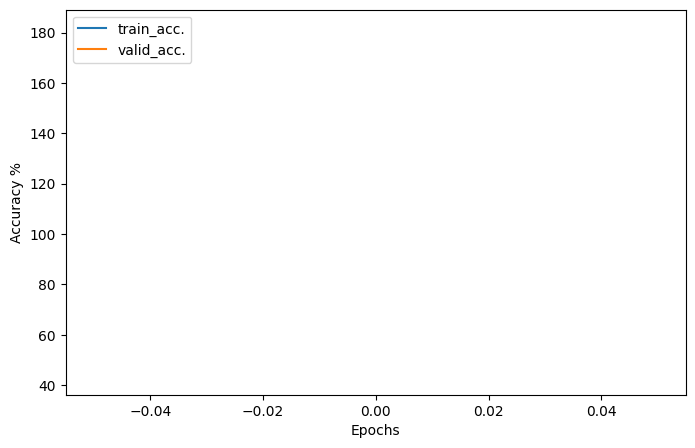

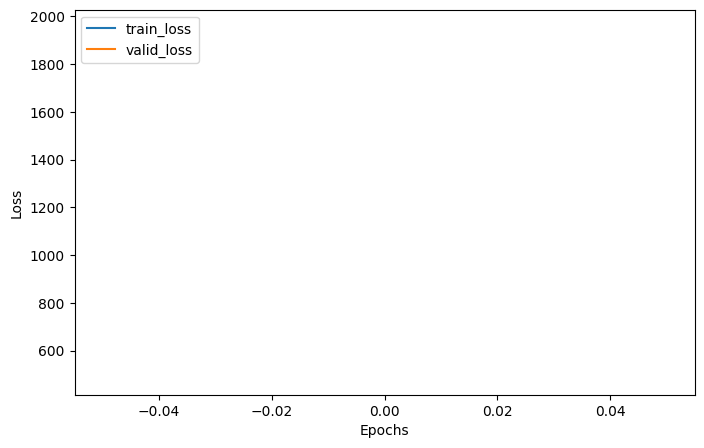

Training...: 100%|██████████| 353/353 [01:32<00:00,  3.83it/s, Batch average loss=0.6937]


The saved model is the 1 epoch
Epoch 2 | Average train loss: 0.6927 / Average train Acc: 0.0669 
Average valid loss: 0.693 / Average valid Acc: 0.0638 

Best epoch is 2


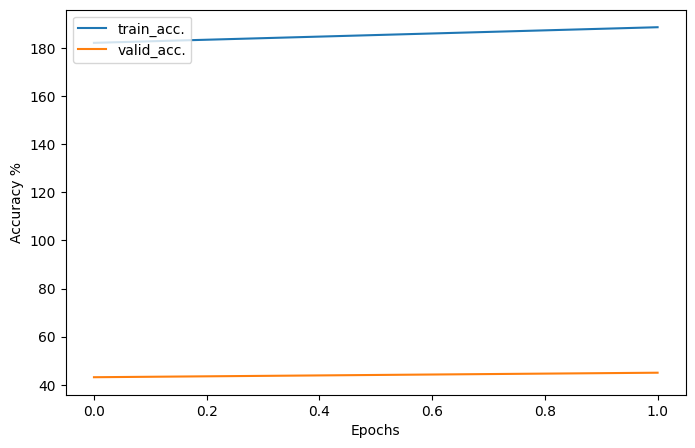

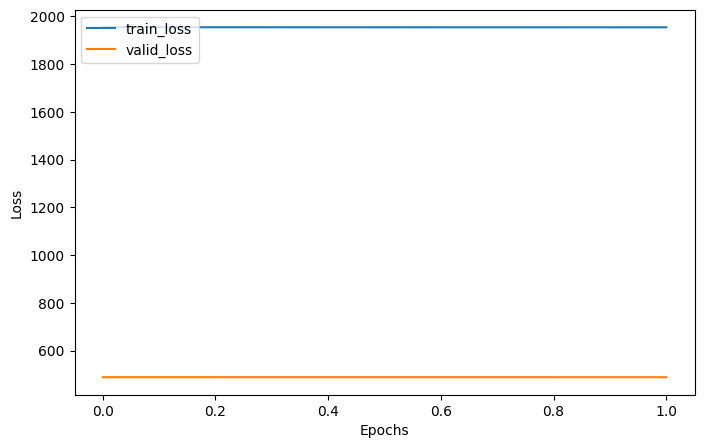

Training...: 100%|██████████| 353/353 [01:29<00:00,  3.95it/s, Batch average loss=0.6883]


The saved model is the 2 epoch
Epoch 3 | Average train loss: 0.6929 / Average train Acc: 0.0648 
Average valid loss: 0.6928 / Average valid Acc: 0.0649 

Best epoch is 3


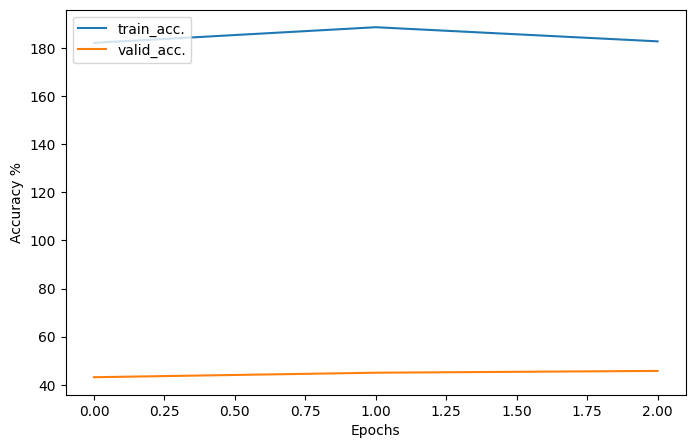

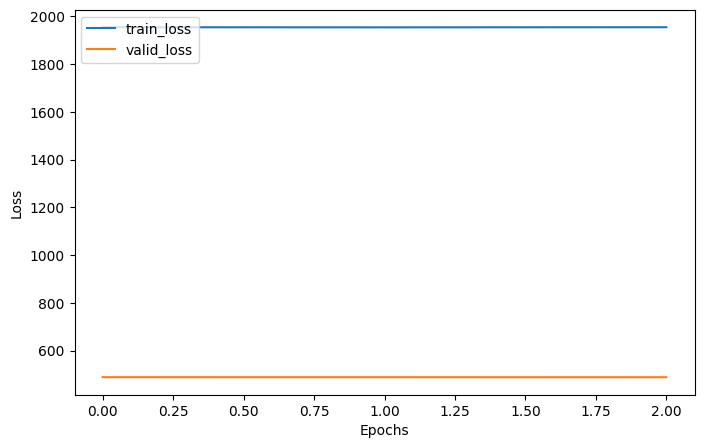

Training...: 100%|██████████| 353/353 [01:29<00:00,  3.94it/s, Batch average loss=0.6933]


Epoch 4 | Average train loss: 0.6928 / Average train Acc: 0.0643 
Average valid loss: 0.6932 / Average valid Acc: 0.0633 

Best epoch is 3


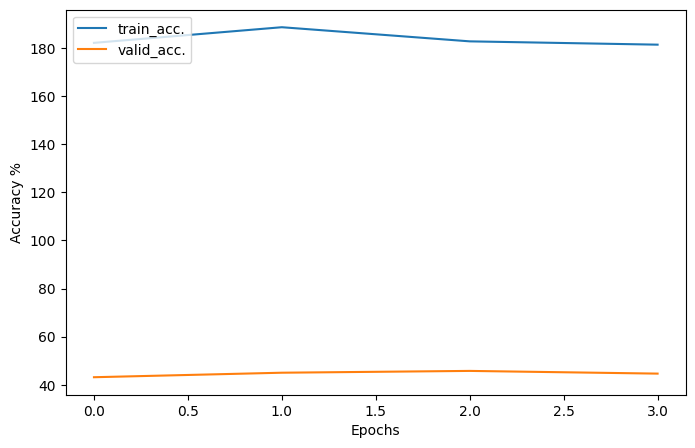

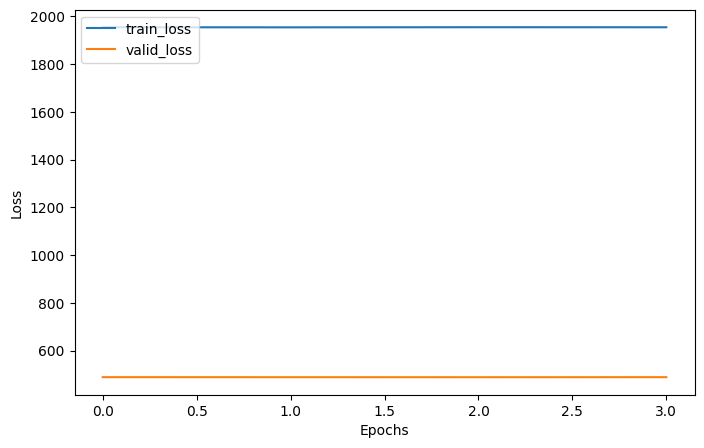

Training...: 100%|██████████| 353/353 [01:29<00:00,  3.93it/s, Batch average loss=0.6949]


Epoch 5 | Average train loss: 0.6928 / Average train Acc: 0.0656 
Average valid loss: 0.6929 / Average valid Acc: 0.0652 

Best epoch is 3


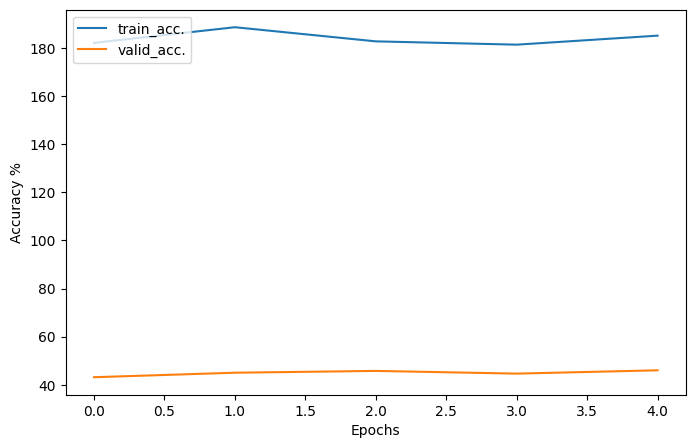

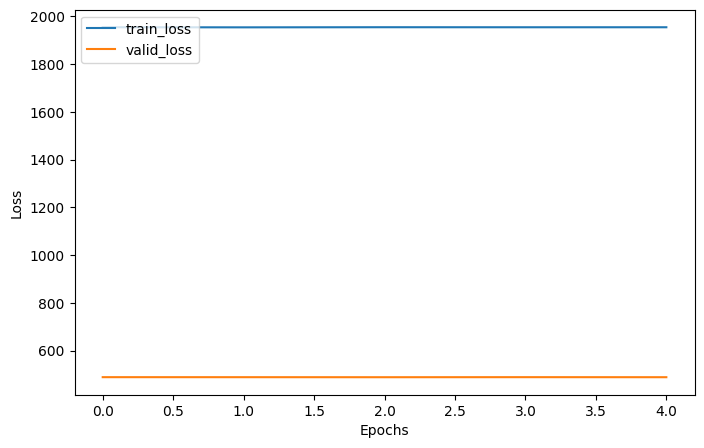

Training...: 100%|██████████| 353/353 [01:30<00:00,  3.89it/s, Batch average loss=0.6930]


Epoch 6 | Average train loss: 0.693 / Average train Acc: 0.0645 
Average valid loss: 0.6928 / Average valid Acc: 0.0672 

Best epoch is 3


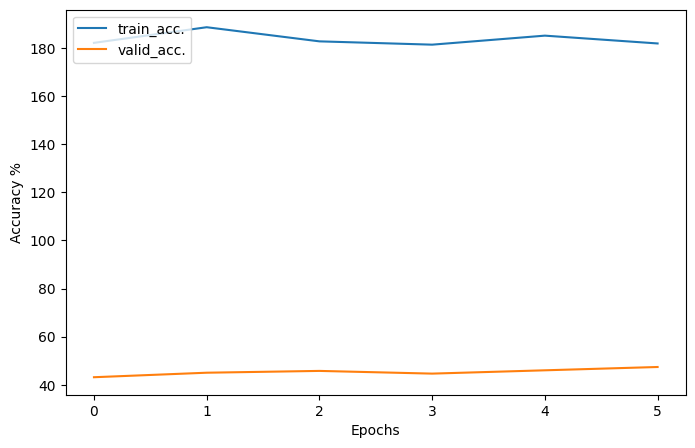

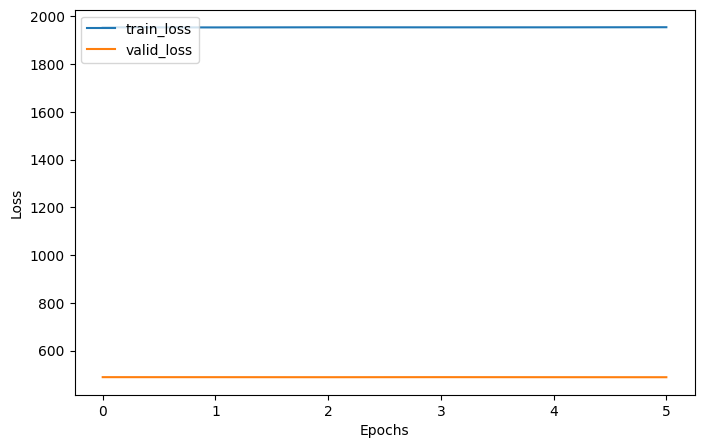

Training...: 100%|██████████| 353/353 [01:32<00:00,  3.80it/s, Batch average loss=0.6924]


Epoch 7 | Average train loss: 0.6928 / Average train Acc: 0.0638 
Average valid loss: 0.6933 / Average valid Acc: 0.0631 

Best epoch is 3


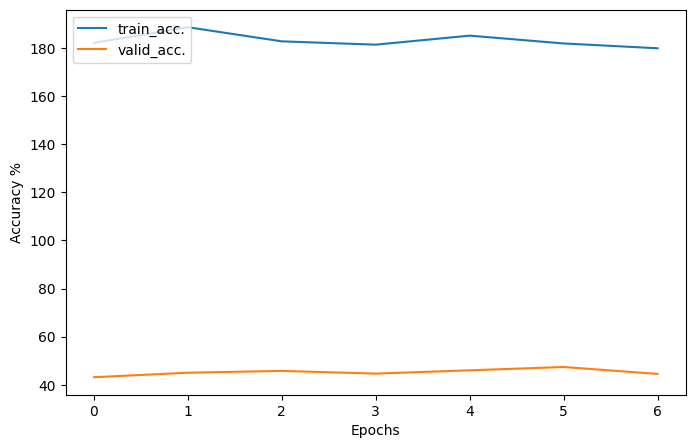

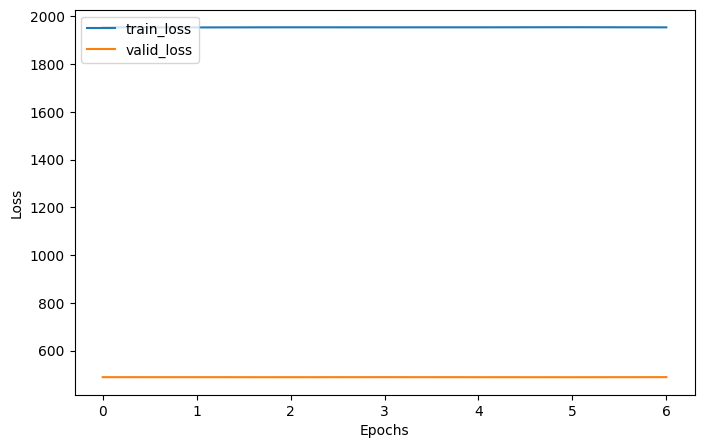

Training...: 100%|██████████| 353/353 [01:30<00:00,  3.90it/s, Batch average loss=0.6898]


The saved model is the 7 epoch
Epoch 8 | Average train loss: 0.6931 / Average train Acc: 0.0625 
Average valid loss: 0.6922 / Average valid Acc: 0.0704 

Best epoch is 8


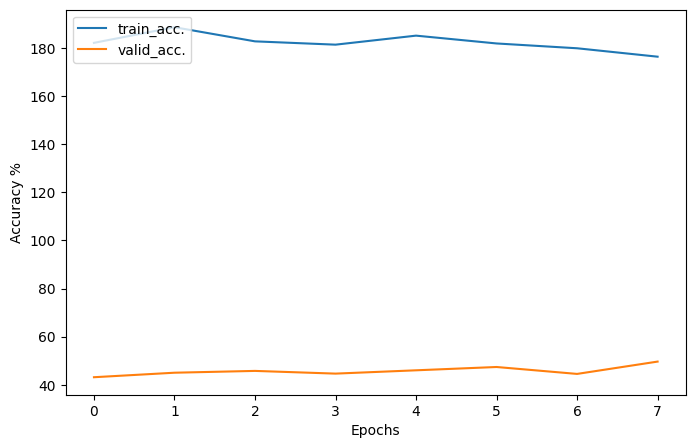

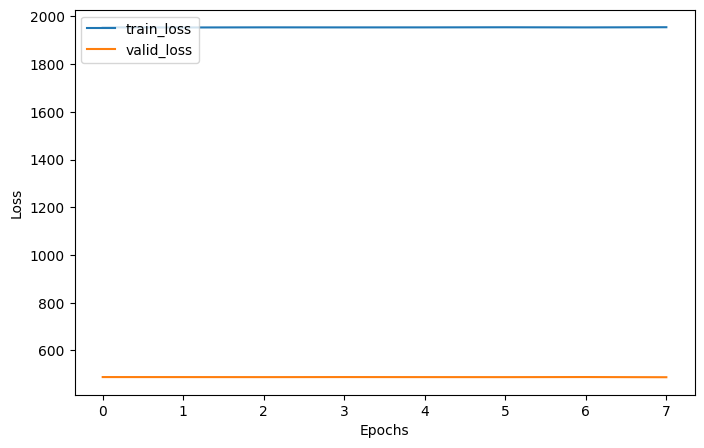

Training...: 100%|██████████| 353/353 [01:28<00:00,  3.99it/s, Batch average loss=0.6924]


Epoch 9 | Average train loss: 0.6929 / Average train Acc: 0.0641 
Average valid loss: 0.693 / Average valid Acc: 0.0663 

Best epoch is 8


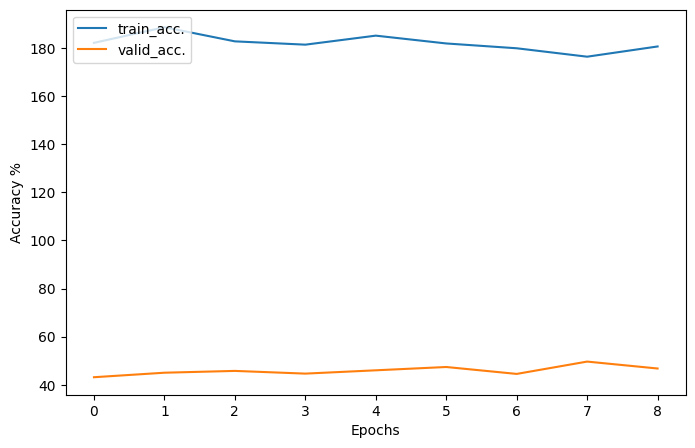

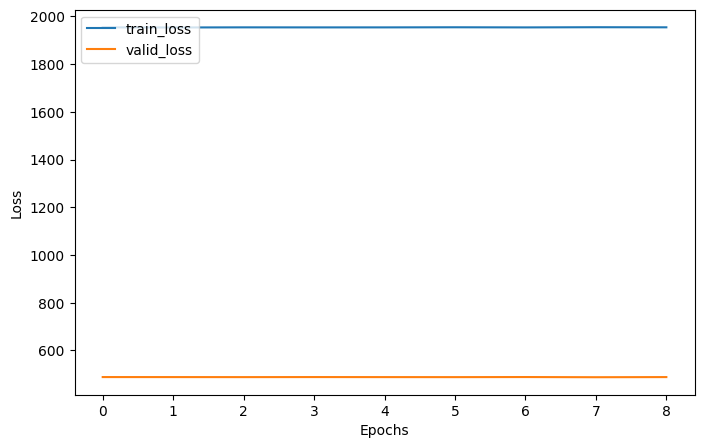

Training...: 100%|██████████| 353/353 [01:26<00:00,  4.06it/s, Batch average loss=0.6908]


Epoch 10 | Average train loss: 0.693 / Average train Acc: 0.0635 
Average valid loss: 0.6927 / Average valid Acc: 0.0686 

Best epoch is 8


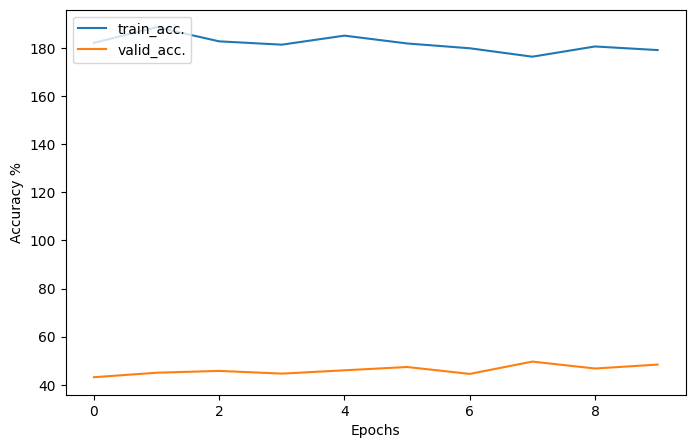

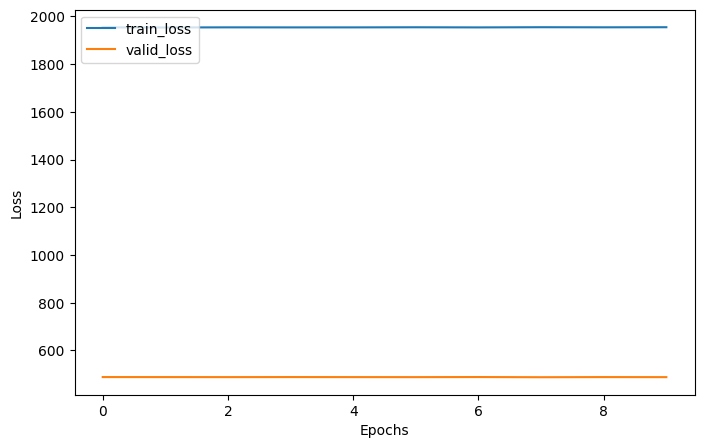

Training...: 100%|██████████| 353/353 [01:27<00:00,  4.02it/s, Batch average loss=0.6922]


Epoch 11 | Average train loss: 0.6928 / Average train Acc: 0.0641 
Average valid loss: 0.6927 / Average valid Acc: 0.0661 

Best epoch is 8


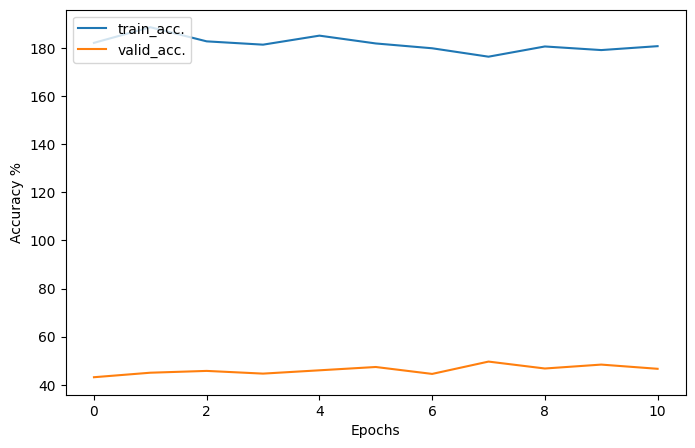

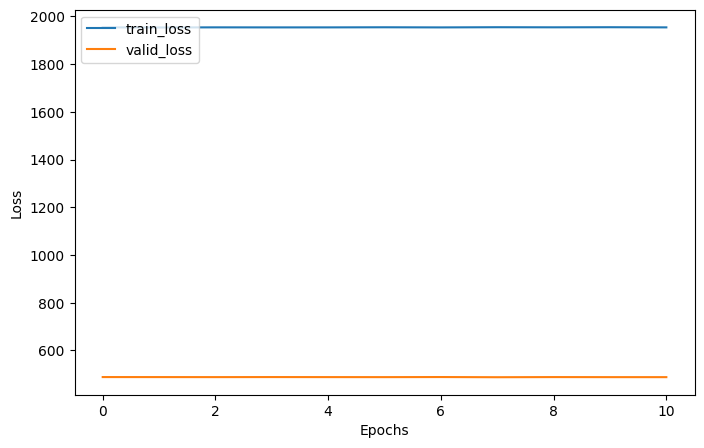

Training...: 100%|██████████| 353/353 [01:29<00:00,  3.95it/s, Batch average loss=0.6938]


Epoch 12 | Average train loss: 0.6929 / Average train Acc: 0.0642 
Average valid loss: 0.6929 / Average valid Acc: 0.064 

Best epoch is 8


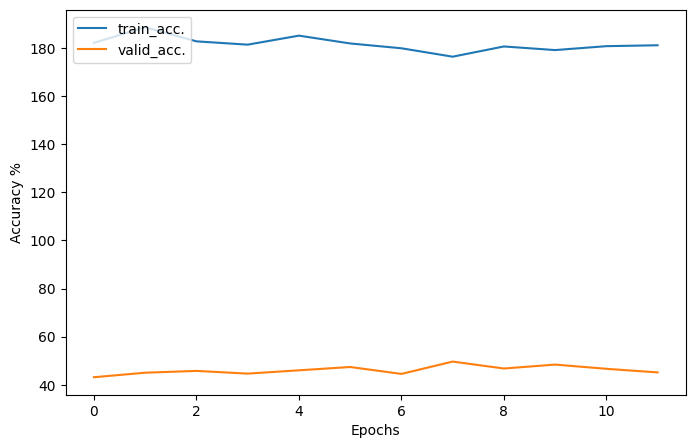

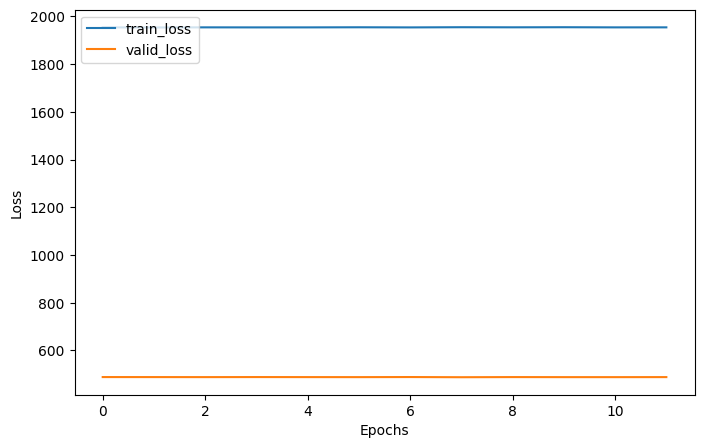

Training...: 100%|██████████| 353/353 [01:27<00:00,  4.02it/s, Batch average loss=0.6949]


Epoch 13 | Average train loss: 0.6931 / Average train Acc: 0.0631 
Average valid loss: 0.6928 / Average valid Acc: 0.0637 

Best epoch is 8


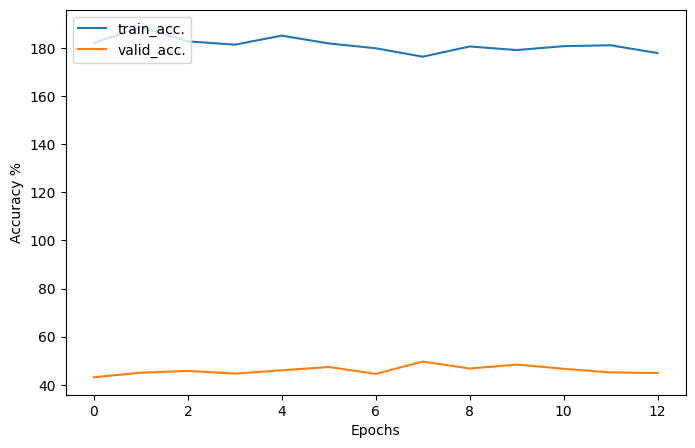

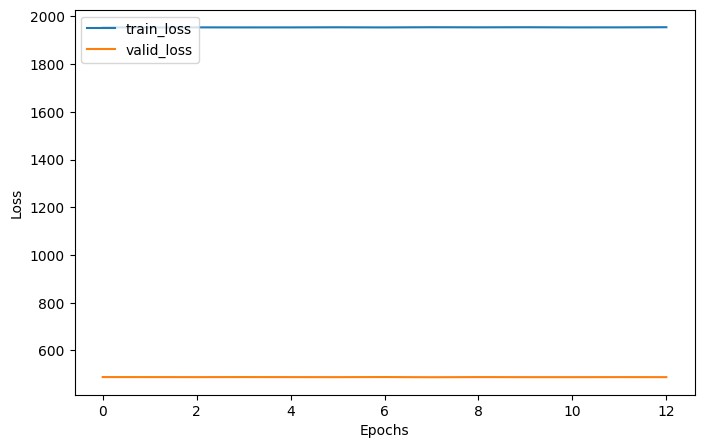

Training...: 100%|██████████| 353/353 [01:28<00:00,  3.99it/s, Batch average loss=0.6913]


Epoch 14 | Average train loss: 0.6929 / Average train Acc: 0.0656 
Average valid loss: 0.693 / Average valid Acc: 0.0635 

Best epoch is 8


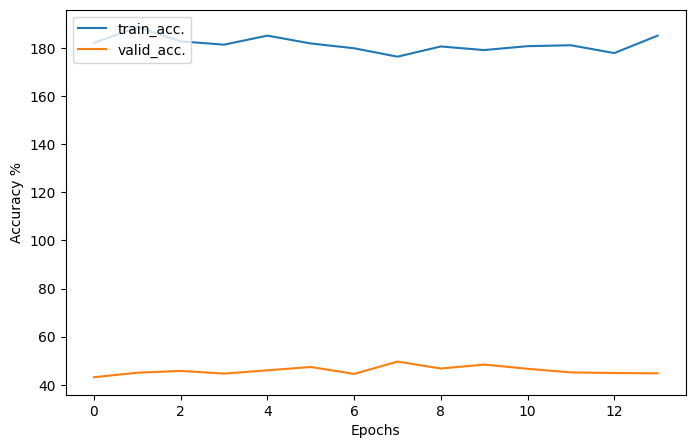

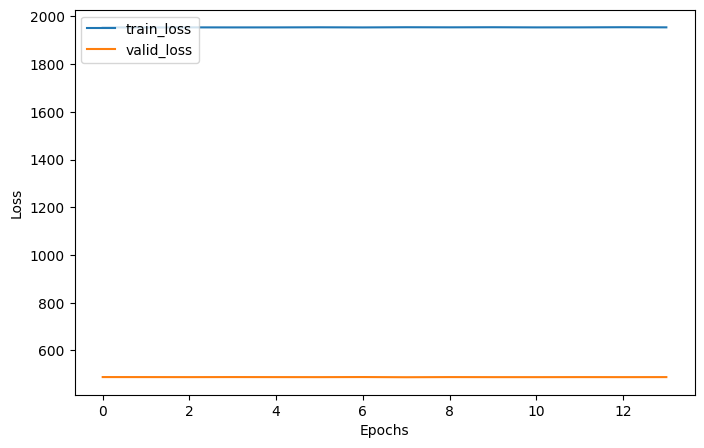

Training...: 100%|██████████| 353/353 [01:27<00:00,  4.05it/s, Batch average loss=0.6920]


Epoch 15 | Average train loss: 0.6927 / Average train Acc: 0.0664 
Average valid loss: 0.6928 / Average valid Acc: 0.0649 

Best epoch is 8


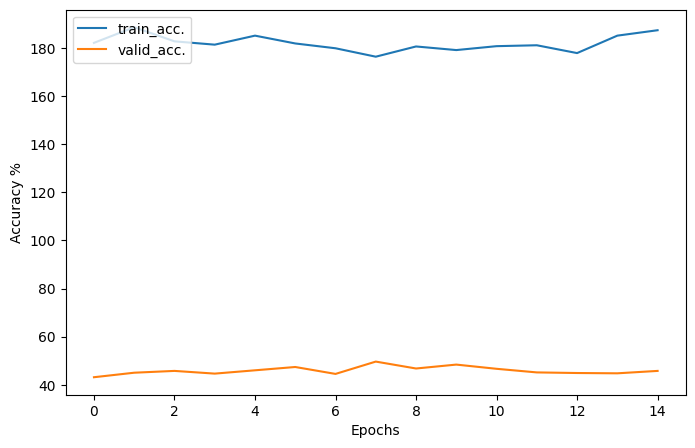

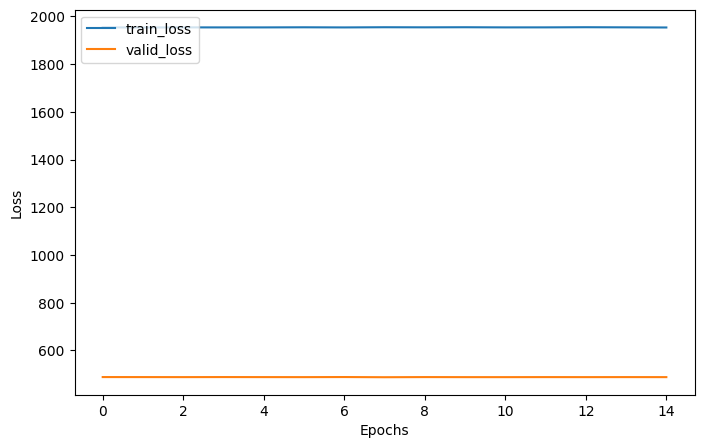

Training...:   6%|▌         | 21/353 [00:05<01:22,  4.04it/s, Batch average loss=0.6886]


KeyboardInterrupt: 

In [19]:
#training
epochs = 50
best_valid_loss = 10
best_epoch = 0


loss_train_list = []
loss_valid_list = []
acc_train_list = []
acc_valid_list = []


for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0

    bar = tqdm(train_loader)
    bar.set_description(f"Training...")
    
    # Training the model
    model.train()
    resnet.train()
    for batch, (inputs, labels) in enumerate(bar):
        # Move to device
        inputs, labels = inputs.to(device), labels.type(torch.ByteTensor).to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        resnet_input = output.detach()
        resnet_output = resnet(resnet_input)
        # Loss
        loss = criterion(resnet_output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)

        # Since our model outputs a LogSoftmax, find the real 
        # percentages by reversing the log function
        output = torch.exp(output)
        # Get the top class of the output
        top_p, top_class = output.topk(1, dim=1)
        # See how many of the classes were correct?
        equals = top_class == labels.view(*top_class.shape)
        # Calculate the mean (get the accuracy for this batch)
        # and add it to the running accuracy for this epoch
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Print the progress of our training
        if batch % 100 == 0:
          bar.set_postfix({"Batch average loss": f"{loss.item():.4f}"})
        
    # Evaluating the model
    model.eval()
    resnet.eval()
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.type(torch.ByteTensor).to(device)
            # Forward pass
            output = model.forward(inputs)
            inputs = output.detach()
            output = resnet(inputs) 
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(resnet_output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    
    # Get the average loss for the entire epoch
    avg_train_loss = round(train_loss/len(train_loader.dataset), 4)
    avg_valid_loss = round(val_loss/len(val_loader.dataset), 4)
    avg_train_acc = round(train_accuracy / len(train_loader.dataset), 4)
    avg_val_acc = round(val_accuracy / len(val_loader.dataset), 4)

    if (avg_valid_loss<best_valid_loss):
      best_valid_loss = avg_valid_loss
      best_epoch = epoch+1
      torch.save(model.state_dict(), 'DL_final1/checkpoint_unet.pth')
      print('The saved model is the {} epoch'.format(epoch))
    
    loss_train_list.append(avg_train_loss)
    loss_valid_list.append(avg_valid_loss)
    acc_train_list.append(avg_train_acc)
    acc_valid_list.append(avg_val_acc)

    # Print out the information
    print(f"Epoch {epoch+1} | Average train loss: {avg_train_loss} / Average train Acc: {avg_train_acc} ")
    print(f"Average valid loss: {avg_valid_loss} / Average valid Acc: {avg_val_acc} \n")
    print('Best epoch is {}'.format(best_epoch))
    
    plt.figure(figsize=(8, 5))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy %")

    plt.plot(acc_train_list, label = "train_acc.")
    plt.plot(acc_valid_list, label = "valid_acc.")
    plt.legend(loc=2)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.plot(loss_train_list, label = "train_loss")
    plt.plot(loss_valid_list, label = "valid_loss")
    plt.legend(loc=2)
    plt.show()


In [ ]:
#testing
#evaluation mode
model.eval()
result = []  #storing the result of prediction (probability of being positive/abnormal)
count = 0
with torch.no_grad(): #don't calculate the gradient
    for inputs in test_loader:
        # Move to device
        inputs = inputs.to(device)
        # Forward pass
        output = model.forward(inputs)
        count += 1
        print(count,'/',len(test_loader))
        #store the result
        result.append(np.exp(float((output[0][1]).cpu())))

#output the prediction
#generate list of image id
test_folder = 'data_path/test'
image_id = []
for i in range (len(test_paths)):
    image_id.append(test_paths[i][-len(test_paths[i])+len(test_folder)+1:-11])
#build data frame for pandas library
df = pd.DataFrame({'id':image_id,
                  'label':result})
#construct csv file for submission
df.to_csv('DL_final1/submission.csv',index=False)

In [ ]:
#save the checkpoint
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

torch.save(model.state_dict(), 'DL_final1/1119-3_50epochs.pth')

# download checkpoint file
#files.download('/content/drive/My Drive/Colab Notebooks/checkpoint.pth')



In [ ]:
#upload the checkpoint file
state_dict = torch.load('DL_final1/checkpoint.pth')
print(state_dict.keys())

#load the state dictionary to model
model.load_state_dict(state_dict)

print(model)